In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

In [2]:
internal_train = pd.read_csv('../3_cleandata/train_1.csv')
internal_test = pd.read_csv('../3_cleandata/test_1.csv')

In [3]:
internal_train.shape

(201917, 139)

In [4]:
external_test = pd.read_csv('../3_cleandata/test_ext1.csv')
external_train = pd.read_csv('../3_cleandata/train_ext1.csv')


In [5]:
target = pd.read_csv('../3_cleandata/target_int.csv',header= None)

In [6]:
external_train.shape

(201917, 215)

In [7]:
external_train.head()

,first_active_month,feature_1,feature_2,feature_3,target,outliers,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,...,month_lag_min,category_1_mean,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,CLV_ratio,CLV_sq
0,2017-06-01,0.013145,0.00875,0.011430,-0.8203,0,2,604,3020,0.008280,...,-7.0,0.00000,-13.470,-16.78,5.540,-0.11050,-0.1330,0.04584,0.007045,108812.65000
1,2017-01-01,0.010710,0.01138,0.010284,0.3928,0,1,755,3020,0.005300,...,-11.0,0.08856,-16.160,-18.47,1.180,-0.11145,-0.1283,0.00815,0.000349,13576.58700
2,2016-08-01,0.010610,0.00875,0.010284,0.6880,0,3,908,1816,0.002203,...,-11.0,0.00000,-15.220,-16.44,-9.305,-0.12494,-0.1301,-0.07690,0.000562,7.21371
3,2017-09-01,0.010710,0.01417,0.010284,0.1425,0,3,512,2048,0.007812,...,-4.0,0.29880,-14.484,-16.92,2.562,-0.11960,-0.1384,0.02124,0.008454,1038.37830
4,2017-11-01,0.008060,0.01417,0.010284,-0.1598,0,4,451,451,0.002218,...,-2.0,0.16830,-12.310,-16.72,13.760,-0.10175,-0.1377,0.11380,0.071696,59269.74200


In [8]:
internal_train.head()

,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,...,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_sum,authorized_flag_mean,card_id,first_active_month
0,1.597335,0.338839,0.876431,-0.466376,0.311084,-0.234615,-0.548342,1.203092,-0.209665,-0.432998,...,-0.098800,-0.041617,-0.085851,-0.053041,-0.024789,-0.035181,1.667028,0.494966,C_ID_92a2005557,2017-06-01
1,0.754276,-0.992082,-1.140992,0.047738,0.150070,0.011414,0.048638,0.798033,-0.209665,-0.432998,...,0.252809,0.279891,0.288626,0.225142,0.202897,0.323511,2.594044,0.657240,C_ID_3d0044924f,2017-01-01
2,-0.931842,0.338839,-1.140992,0.568661,-0.574497,-0.234615,-0.548342,-1.024733,-0.209665,-0.432998,...,-0.116381,-0.081152,-0.127460,-0.093761,NaN,NaN,-0.408683,0.525447,C_ID_d639edf6cd,2016-08-01
3,0.754276,1.669759,-1.140992,-0.779611,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.045938,0.931856,C_ID_186d6a6901,2017-09-01
4,-1.774901,1.669759,-1.140992,-0.987299,-0.332975,0.134429,1.421691,-1.024733,-0.209665,-0.432998,...,0.569258,0.672080,0.413451,0.484505,-0.065333,-0.085980,0.467952,0.603368,C_ID_cdbd2c0db2,2017-11-01


In [9]:
cols = ['hist_Christmas_Day_2017_mean','hist_Christmas_Day_2017_sum', 'hist_Mothers_Day_2017_mean',
 'hist_Mothers_Day_2017_sum', 'hist_fathers_day_2017_mean', 'hist_fathers_day_2017_sum',
 'hist_Children_day_2017_mean', 'hist_Children_day_2017_sum', 'hist_Valentine_Day_2017_mean',
 'hist_Valentine_Day_2017_sum', 'hist_Black_Friday_2017_mean', 'hist_Black_Friday_2017_sum',
 'hist_Mothers_Day_2018_mean', 'hist_Mothers_Day_2018_sum', 'CLV_ratio',
 'CLV_sq', 'new_Christmas_Day_2017_mean', 'new_Christmas_Day_2017_sum',
 'new_Children_day_2017_mean', 'new_Children_day_2017_sum', 'new_Black_Friday_2017_mean','new_Black_Friday_2017_sum',
 'new_Mothers_Day_2018_mean', 'new_Mothers_Day_2018_sum',]

def joining_dataset(internal, external,cols):
    combine = pd.concat([internal,external[cols]] ,axis=1, join='inner')
    return combine

train = joining_dataset(internal= internal_train, external= external_train, cols = cols)
test = joining_dataset(internal= internal_test, external= external_test, cols = cols)

In [10]:
train.shape

(201917, 163)

In [11]:
test.shape

(123623, 163)

In [12]:
#exclude the card_id and first_active month in the features 
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#create a list of categorical features 
categorical_feats = [c for c in features if 'feature_' in c]

In [13]:
#lightgbm configuration
param = {'num_leaves': 50,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [14]:
folds = KFold(n_splits=10, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 300)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 3.716	valid_1's rmse: 3.82923
[200]	training's rmse: 3.63947	valid_1's rmse: 3.78551
[300]	training's rmse: 3.58601	valid_1's rmse: 3.76353
[400]	training's rmse: 3.54468	valid_1's rmse: 3.74925
[500]	training's rmse: 3.51057	valid_1's rmse: 3.74076
[600]	training's rmse: 3.48119	valid_1's rmse: 3.73494
[700]	training's rmse: 3.45507	valid_1's rmse: 3.73058
[800]	training's rmse: 3.43218	valid_1's rmse: 3.72666
[900]	training's rmse: 3.41078	valid_1's rmse: 3.72411
[1000]	training's rmse: 3.39066	valid_1's rmse: 3.72155
[1100]	training's rmse: 3.37183	valid_1's rmse: 3.71957
[1200]	training's rmse: 3.35456	valid_1's rmse: 3.71861
[1300]	training's rmse: 3.33891	valid_1's rmse: 3.71742
[1400]	training's rmse: 3.32345	valid_1's rmse: 3.71606
[1500]	training's rmse: 3.30877	valid_1's rmse: 3.71549
[1600]	training's rmse: 3.29447	valid_1's rmse: 3.71483
[1700]	training's rmse: 3.28103	valid_1's rmse: 3.71

[1800]	training's rmse: 3.26959	valid_1's rmse: 3.68367
Early stopping, best iteration is:
[1545]	training's rmse: 3.3049	valid_1's rmse: 3.68349
fold n°6
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 3.70334	valid_1's rmse: 3.93607
[200]	training's rmse: 3.6257	valid_1's rmse: 3.89523
[300]	training's rmse: 3.57079	valid_1's rmse: 3.87509
[400]	training's rmse: 3.5279	valid_1's rmse: 3.86399
[500]	training's rmse: 3.49273	valid_1's rmse: 3.85882
[600]	training's rmse: 3.46258	valid_1's rmse: 3.85437
[700]	training's rmse: 3.43594	valid_1's rmse: 3.85132
[800]	training's rmse: 3.41292	valid_1's rmse: 3.84886
[900]	training's rmse: 3.39166	valid_1's rmse: 3.8472
[1000]	training's rmse: 3.3712	valid_1's rmse: 3.84587
[1100]	training's rmse: 3.35221	valid_1's rmse: 3.84497
[1200]	training's rmse: 3.33438	valid_1's rmse: 3.84454
[1300]	training's rmse: 3.31727	valid_1's rmse: 3.84439
[1400]	training's rmse: 3.30154	valid_1's rmse: 3.84417
[1500]	trai

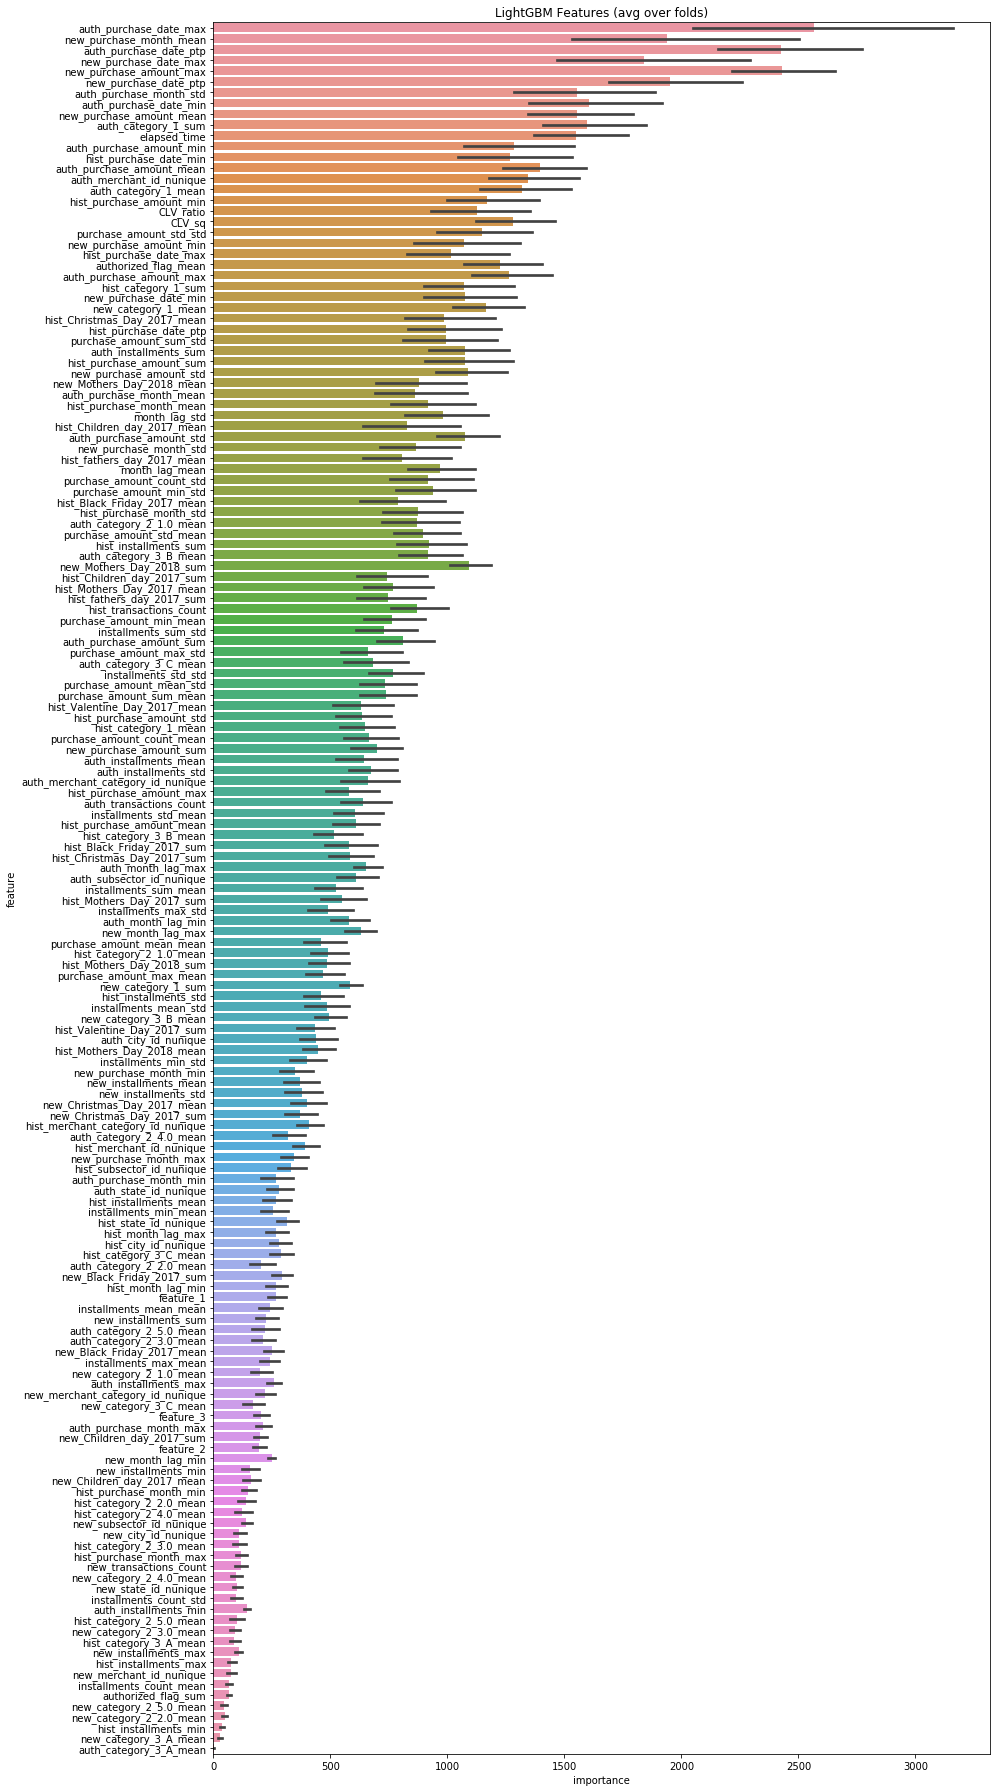

In [15]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../5_submission/lgbm_importances.png')

In [16]:
lgbparam = {'num_leaves': 31,
#             'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': 12,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [17]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=10, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 100000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 300)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0


/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[860]	training's rmse: 3.41933	valid_1's rmse: 3.57552
fold n°1
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1873]	training's rmse: 3.22919	valid_1's rmse: 3.79217
fold n°2
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1167]	training's rmse: 3.37695	valid_1's rmse: 3.43376
fold n°3
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[2696]	training's rmse: 3.15468	valid_1's rmse: 3.6339
fold n°4
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1186]	training's rmse: 3.33371	valid_1's rmse: 3.8254
fold n°5
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1446]	training's rmse: 3.29571	valid_1's rmse: 3.82649
fold n°6
Training until validation

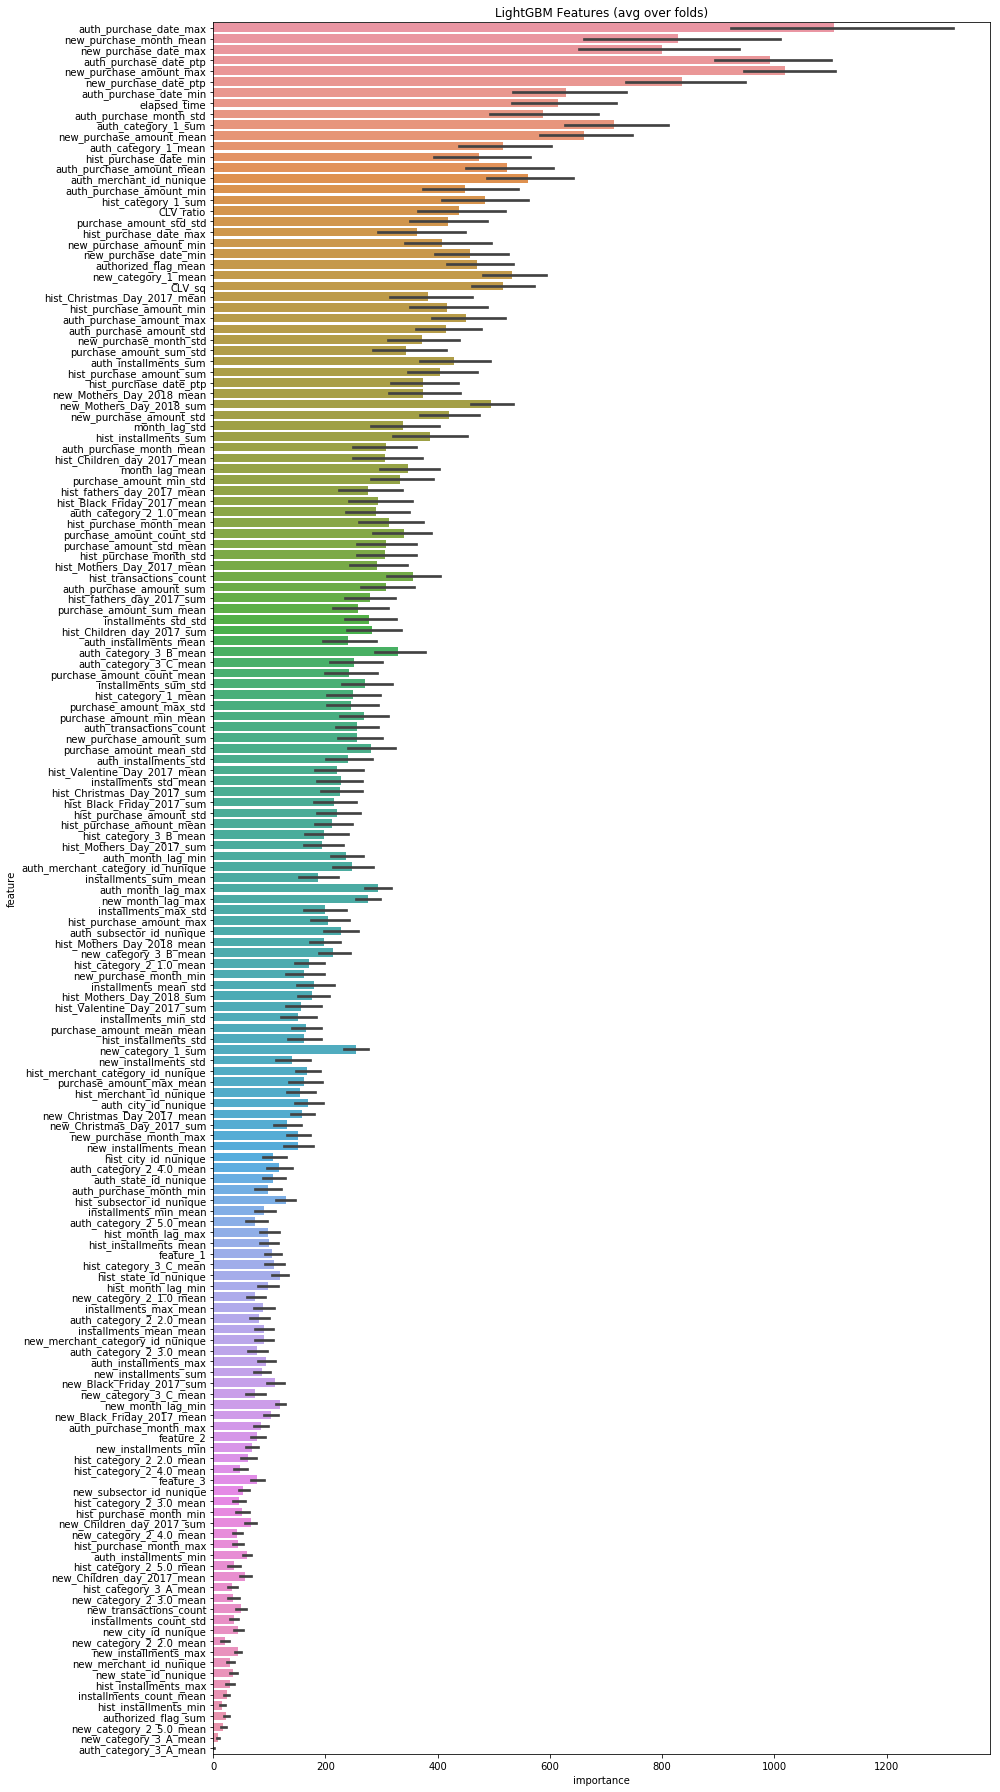

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [19]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb.csv", index=False)

sub_df1 = pd.DataFrame({"card_id":test["card_id"].values})
sub_df1["target"] = predictions_lgb
sub_df1.to_csv("submit_lgb1.csv", index=False)

# Stacking

In [20]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tung/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed w

3.6645126001197657

In [22]:
sample_submission = pd.read_csv('../1_rawdata/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('../5_submission/Bayesian_Ridge_Stacking.csv', index=False)

In [26]:
sample_submission = pd.read_csv('../1_rawdata/sample_submission.csv')
sample1 = pd.read_csv("../5_submission/3.695.csv")
sample2 = pd.read_csv("../5_submission/combining_submission (1).csv")
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("../5_submission/CV3667_LB3689_090219_Blend1.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('../5_submission/CV3667_LB3689_090219_Blend2.csv', index=False)